# Cấp quyền truy cập cho google drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install keras

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Kết nối dữ liệu từ google drive

In [0]:
train_dir = '/content/drive/Colab/BW/Data/Train'
validation_dir = '/content/drive/Colab/BW/Data/Validation'
test_dir = '/content/drive/Colab/BW/Data/Test'
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=180,
                width_shift_range=0.09,
                height_shift_range=0.18,
                shear_range=0.15,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(256, 256),
                batch_size=128,
                class_mode='categorical')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
                validation_dir,
                target_size=(256, 256),
                class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size=(256, 256),
                class_mode='categorical')

Found 263 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Found 10 images belonging to 4 classes.


# Xây dựng kiến trúc mô hình huấn luyện

In [0]:
from keras import layers
from keras import models
from keras import applications
model = models.Sequential()
conv_base = applications.VGG16(weights='imagenet', 
                               include_top=False, 
                               input_shape=[256, 256, 3]) 
conv_base.trainable = False
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

from keras import optimizers
model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
______________________

# Huấn luyện 

In [0]:
from keras import callbacks
mc = callbacks.ModelCheckpoint('/content/drive/Colab/BW/VGG16/weightsV2{epoch:08d}.h5', 
                                     save_weights_only=True, period=10)
history = model.fit_generator(
                train_generator,
                steps_per_epoch=50,
                epochs=50,
                callbacks=[mc],
                validation_data=validation_generator,
                validation_steps=50
                )

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
50/50 [==============================] - 153s 3s/step - loss: 1.3211 - acc: 0.4210 - val_loss: 1.3442 - val_acc: 0.4000
Epoch 2/50
50/50 [==============================] - 77s 2s/step - loss: 1.1139 - acc: 0.5213 - val_loss: 1.2478 - val_acc: 0.5000
Epoch 3/50
50/50 [==============================] - 77s 2s/step - loss: 1.0014 - acc: 0.6069 - val_loss: 1.0174 - val_acc: 0.5500
Epoch 4/50
50/50 [==============================] - 80s 2s/step - loss: 0.9212 - acc: 0.6158 - val_loss: 0.9761 - val_acc: 0.6000
Epoch 5/50
50/50 [==============================] - 77s 2s/step - loss: 0.8665 - acc: 0.6649 - val_loss: 0.9550 - val_acc: 0.6500
Epoch 6/50
50/50 [==============================] - 78s 2s/step - loss: 0.8311 - acc: 0.6618 - val_loss: 0.8998 - val_acc: 0.7000
Epoch 7/50
50/50 [==============================] - 78s 2s/step - loss: 0.7636 - acc: 0.6894 - val_loss: 0.8473 - val_acc: 0.5500
Epoch 8/50
50/50 [=======================

# Mô hình hiển thị độ chính xác và độ lỗi qua các bước huấn luyện

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


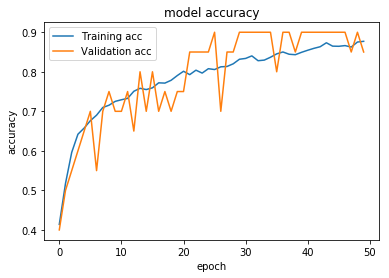

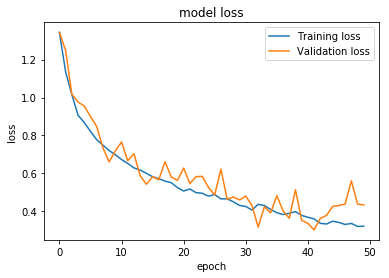

In [0]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'],label='Training acc')
plt.plot(history.history['val_acc'],label='Validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()
# summarize history for loss
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Dự đoán trên tập test sau khi huấn luyện

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                test_dir,
                target_size=(256, 256),
                class_mode='categorical')
import numpy as np
x,y = next(test_generator)
x = np.array(x)
y = np.array(y)
print (x.shape)
prediction_probabilities = model.predict(x)
prediction_probabilities = np.around(prediction_probabilities)
rs = prediction_probabilities - y
print ('label: ')
print (y)
print ('prediction: ')
print (prediction_probabilities)
print ('prediction - label: ')
print (rs)

Found 10 images belonging to 4 classes.
(10, 256, 256, 3)
label: 
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
prediction: 
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
prediction - label: 
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [-1.  0.  1.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
